### improting

In [101]:
!pip install camel-tools tashaphyne
!pip install wordcloud


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

In [8]:
df = pd.read_excel('original_dataset.xlsx')

### Data Profiling

In [9]:
df.head()

,Unnamed: 0,review_description,rating,company
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,1,ابلكيشن زباله بجد,-1,alahli_bank
2,2,سيئ التطبيق لايعمل,-1,alahli_bank
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank


In [10]:
df.tail()

,Unnamed: 0,review_description,rating,company
67122,67122,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels
67123,67123,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels
67124,67124,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels
67125,67125,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels
67126,67126,استقبال سيء جدا وعدم الاستعداد للنزلاء . لا شي...,0,hotels


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67127 entries, 0 to 67126
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          67127 non-null  int64 
 1   review_description  67125 non-null  object
 2   rating              67127 non-null  int64 
 3   company             67127 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,67127.0,33563.000000,19378.040097,0.0,16781.5,33563.0,50344.5,67126.0
rating,67127.0,-0.040163,0.802836,-1.0,-1.0,0.0,1.0,1.0


In [13]:
df

,Unnamed: 0,review_description,rating,company
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,1,ابلكيشن زباله بجد,-1,alahli_bank
2,2,سيئ التطبيق لايعمل,-1,alahli_bank
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank
...,...,...,...,...
67122,67122,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels
67123,67123,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels
67124,67124,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels
67125,67125,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels


In [14]:
df.dtypes

Unnamed: 0             int64
review_description    object
rating                 int64
company               object
dtype: object

In [15]:
df['rating'].value_counts()

rating
 0    23753
-1    23035
 1    20339
Name: count, dtype: int64

In [16]:
df.duplicated().sum()

0

In [17]:
df[df.duplicated()]

,Unnamed: 0,review_description,rating,company


In [18]:
df.isna().sum()

Unnamed: 0            0
review_description    2
rating                0
company               0
dtype: int64

In [19]:
df[df['review_description'].isna()]

,Unnamed: 0,review_description,rating,company
63890,63890,NaN,0,hotels
64405,64405,NaN,0,hotels


### Okay, since there's only two instances that are `nulls`; we can just drop them

In [20]:
df.dropna(subset=['review_description'], inplace=True)

In [21]:
df.isna().sum()

Unnamed: 0            0
review_description    0
rating                0
company               0
dtype: int64

### Ok, and now we'll start with text removing.

#### Why to clean?
- Removing `Special Character` like: emojis
- `Numbers`
- `Punctuation`
- `English letters`..etc.,

In [22]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Remove non-Arabic characters (includes emojis, punctuation, symbols)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove English letters
    text = re.sub(r'[a-zA-Z]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

### This will:
- Keep only Arabic characters.
- Remove numbers, English, punctuation, emojis.
- Return clean Arabic sentences ready for tokenization.

In [23]:
df['cleaned_review_description'] = df['review_description'].apply(clean_text)

In [30]:
df[['cleaned_review_description', 'review_description']].head(15)

,cleaned_review_description,review_description
0,سيئ جدا بعد الإصدار الجديد,سيئ جدا بعد الإصدار الجديد
1,ابلكيشن زباله بجد,ابلكيشن زباله بجد
2,سيئ التطبيق لايعمل,سيئ التطبيق لايعمل
3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...
4,التحديث بطيئ جدا جدا عند الفتح,التحديث بطيئ جدا جدا عند الفتح
5,مرررره زق من بعد اخر تحديث ما فتحلي ابدآ ويرفض...,مرررره زق من بعد اخر تحديث ما فتحلي ابدآ ويرفض...
6,التطبيق ما يشتغل كل ما اعمل تسجيل دخول على حسا...,التطبيق ما يشتغل كل ما اعمل تسجيل دخول على حسا...
7,اذا قمت بفتح التطبيق يطلب تحديث واذا ضغطت على ...,اذا قمت بفتح التطبيق يطلب تحديث واذا ضغطت على ...
8,للاسف سيئ جدا من امس احاول استخدمه مافي اتواصل...,للاسف سيئ جدا من امس احاول استخدمه مافي اتواصل...
9,صراحه شي موسف,صراحه شي موسف


## Now, We Do Arabic Text Normalization 

In this step, we normalize the Arabic text by:
- Unifying different forms of the same letter (like أ → ا)
- Removing diacritics (التشكيل) like َ ُ ِ ّ etc.

### Why?
Normalization helps reduce word variety and makes it easier for the model to learn.
For example:
- "أكل", "اكل", and "أكلَ" are all treated as the same root word.

In [28]:
def normalize_text(text):
    text = normalize_unicode(text)  # Normalize Arabic letters (e.g., أ → ا)
    text = dediac_ar(text)          # Remove diacritics (التشكيل)
    return text

In [29]:
df['Normalized_review_description'] = df['cleaned_review_description'].apply(normalize_text)

In [31]:
df[['review_description', 'cleaned_review_description', 'Normalized_review_description']].head(15)

,review_description,cleaned_review_description,Normalized_review_description
0,سيئ جدا بعد الإصدار الجديد,سيئ جدا بعد الإصدار الجديد,سيئ جدا بعد الإصدار الجديد
1,ابلكيشن زباله بجد,ابلكيشن زباله بجد,ابلكيشن زباله بجد
2,سيئ التطبيق لايعمل,سيئ التطبيق لايعمل,سيئ التطبيق لايعمل
3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...
4,التحديث بطيئ جدا جدا عند الفتح,التحديث بطيئ جدا جدا عند الفتح,التحديث بطيئ جدا جدا عند الفتح
5,مرررره زق من بعد اخر تحديث ما فتحلي ابدآ ويرفض...,مرررره زق من بعد اخر تحديث ما فتحلي ابدآ ويرفض...,مرررره زق من بعد اخر تحديث ما فتحلي ابدآ ويرفض...
6,التطبيق ما يشتغل كل ما اعمل تسجيل دخول على حسا...,التطبيق ما يشتغل كل ما اعمل تسجيل دخول على حسا...,التطبيق ما يشتغل كل ما اعمل تسجيل دخول على حسا...
7,اذا قمت بفتح التطبيق يطلب تحديث واذا ضغطت على ...,اذا قمت بفتح التطبيق يطلب تحديث واذا ضغطت على ...,اذا قمت بفتح التطبيق يطلب تحديث واذا ضغطت على ...
8,للاسف سيئ جدا من امس احاول استخدمه مافي اتواصل...,للاسف سيئ جدا من امس احاول استخدمه مافي اتواصل...,للاسف سيئ جدا من امس احاول استخدمه مافي اتواصل...
9,صراحه شي موسف,صراحه شي موسف,صراحه شي موسف


In [32]:
df.head()

,Unnamed: 0,review_description,rating,company,cleaned_review_description,Normalized_review_description
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank,سيئ جدا بعد الإصدار الجديد,سيئ جدا بعد الإصدار الجديد
1,1,ابلكيشن زباله بجد,-1,alahli_bank,ابلكيشن زباله بجد,ابلكيشن زباله بجد
2,2,سيئ التطبيق لايعمل,-1,alahli_bank,سيئ التطبيق لايعمل,سيئ التطبيق لايعمل
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank,التحديث بطيئ جدا جدا عند الفتح,التحديث بطيئ جدا جدا عند الفتح


## Now, It's Time to Do `Tokenization` of The Words
 ### Split each Arabic sentence into individual words (tokens).

In this step, we break the Arabic sentence into individual words (tokens).  
This is important for:
- Removing stopwords later
- Stemming each word
- Afterwards, converting the sentence into numeric features (TF-IDF)

In [34]:
df['tokens'] = df['Normalized_review_description'].apply(simple_word_tokenize)

In [36]:
df[['Normalized_review_description', 'tokens']].head(15)

,Normalized_review_description,tokens
0,سيئ جدا بعد الإصدار الجديد,"[سيئ, جدا, بعد, الإصدار, الجديد]"
1,ابلكيشن زباله بجد,"[ابلكيشن, زباله, بجد]"
2,سيئ التطبيق لايعمل,"[سيئ, التطبيق, لايعمل]"
3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,"[للأسف, التطبيق, للأسوأ, كان, جدا, رائع, وسهل,..."
4,التحديث بطيئ جدا جدا عند الفتح,"[التحديث, بطيئ, جدا, جدا, عند, الفتح]"
5,مرررره زق من بعد اخر تحديث ما فتحلي ابدآ ويرفض...,"[مرررره, زق, من, بعد, اخر, تحديث, ما, فتحلي, ا..."
6,التطبيق ما يشتغل كل ما اعمل تسجيل دخول على حسا...,"[التطبيق, ما, يشتغل, كل, ما, اعمل, تسجيل, دخول..."
7,اذا قمت بفتح التطبيق يطلب تحديث واذا ضغطت على ...,"[اذا, قمت, بفتح, التطبيق, يطلب, تحديث, واذا, ض..."
8,للاسف سيئ جدا من امس احاول استخدمه مافي اتواصل...,"[للاسف, سيئ, جدا, من, امس, احاول, استخدمه, ماف..."
9,صراحه شي موسف,"[صراحه, شي, موسف]"


In [37]:
token_lists = df['tokens'].tolist()
print(token_lists[:5])

[['سيئ', 'جدا', 'بعد', 'الإصدار', 'الجديد'], ['ابلكيشن', 'زباله', 'بجد'], ['سيئ', 'التطبيق', 'لايعمل'], ['للأسف', 'التطبيق', 'للأسوأ', 'كان', 'جدا', 'رائع', 'وسهل', 'وبسيط', 'الآن', 'معقد', 'ولا', 'يفتح', 'معاك', 'بسهولة', 'ولا', 'تجد', 'كل', 'الخدمات', 'متاحة', 'لك'], ['التحديث', 'بطيئ', 'جدا', 'جدا', 'عند', 'الفتح']]


# Next, We Want to `Stopward Removal` Using `CAMeL` Tools
We use CAMeL’s Morphological Analyzer to identify and remove stopwords based on part-of-speech (POS) tags.

### Why?
Instead of using a fixed list, we detect the function of each word:
- Remove words with POS like:
  - `prep`: prepositions (في، من، على)
  - `conj`: conjunctions (و، أو)
  - `part`: particles (لم، قد، هل)

This gives better results in Arabic NLP.

In [ ]:
# db = MorphologyDB.builtin_db()
# analyzer = Analyzer(db)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\1xopw\\AppData\\Roaming\\camel_tools\\data\\morphology_db\\calima-msa-r13\\morphology.db'

### Since I couldn't solve the DB for now, so I'll just create a `set` containting the stopwards in Arabic

In [54]:
simple_arabic_stopwords = set([
    'في', 'من', 'على', 'أن', 'ما', 'مع', 'كان', 'هو', 'هي', 'كل', 'لم', 'لن',
    'لقد', 'هذا', 'هذه', 'هناك', 'الى', 'إلى', 'عن', 'او', 'أي', 'أو', 'ثم', 'حتى',
    'بين', 'إن', 'ذلك', 'تلك', 'لكن', 'بعد', 'قبل', 'عند', 'لدي', 'له', 'بها', 'به',
    'وقد', 'أكثر', 'أقل', 'أثناء', 'التي', 'الذي', 'كما', 'وأن', 'بأن'
])

In [53]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in simple_arabic_stopwords]

In [55]:
df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)

In [56]:
df[['tokens', 'filtered_tokens']].head(15)

,tokens,filtered_tokens
0,"[سيئ, جدا, بعد, الإصدار, الجديد]","[سيئ, جدا, الإصدار, الجديد]"
1,"[ابلكيشن, زباله, بجد]","[ابلكيشن, زباله, بجد]"
2,"[سيئ, التطبيق, لايعمل]","[سيئ, التطبيق, لايعمل]"
3,"[للأسف, التطبيق, للأسوأ, كان, جدا, رائع, وسهل,...","[للأسف, التطبيق, للأسوأ, جدا, رائع, وسهل, وبسي..."
4,"[التحديث, بطيئ, جدا, جدا, عند, الفتح]","[التحديث, بطيئ, جدا, جدا, الفتح]"
5,"[مرررره, زق, من, بعد, اخر, تحديث, ما, فتحلي, ا...","[مرررره, زق, اخر, تحديث, فتحلي, ابدآ, ويرفض, ا..."
6,"[التطبيق, ما, يشتغل, كل, ما, اعمل, تسجيل, دخول...","[التطبيق, يشتغل, اعمل, تسجيل, دخول, حسابي, يفت..."
7,"[اذا, قمت, بفتح, التطبيق, يطلب, تحديث, واذا, ض...","[اذا, قمت, بفتح, التطبيق, يطلب, تحديث, واذا, ض..."
8,"[للاسف, سيئ, جدا, من, امس, احاول, استخدمه, ماف...","[للاسف, سيئ, جدا, امس, احاول, استخدمه, مافي, ا..."
9,"[صراحه, شي, موسف]","[صراحه, شي, موسف]"


# Next Step is To Do `Stemming`
### What is Stemming?
Stemming is the process of reducing a word to its **base form** or **stem**.

For example:
- "يستخدمون", "استخدام", "تستخدم" → "ستخدم"

### Why?
- Reduces the vocabulary size
- Makes words with similar meanings be treated the same by the model
- Keeps the model focused on meaning, not grammar`

In [57]:
stemming = ArabicLightStemmer()

In [58]:
def stem_tokens(tokens):
    stems = []
    for word in tokens:
        try:
            stemming.light_stem(word)
            stems.append(stemming.get_stem())
        except:
            stems.append(word)
    return stems

In [59]:
df['stemmed_tokens'] = df['filtered_tokens'].apply(stem_tokens)

In [60]:
df[['filtered_tokens', 'stemmed_tokens']].head(15)

,filtered_tokens,stemmed_tokens
0,"[سيئ, جدا, الإصدار, الجديد]","[سيئ, جد, إصدار, جديد]"
1,"[ابلكيشن, زباله, بجد]","[ابلكيشن, زبال, جد]"
2,"[سيئ, التطبيق, لايعمل]","[سيئ, تطبيق, ايعمل]"
3,"[للأسف, التطبيق, للأسوأ, جدا, رائع, وسهل, وبسي...","[أسف, تطبيق, أسوأ, جد, رائع, سهل, سيط, الآن, م..."
4,"[التحديث, بطيئ, جدا, جدا, الفتح]","[تحديث, طيئ, جد, جد, فتح]"
5,"[مرررره, زق, اخر, تحديث, فتحلي, ابدآ, ويرفض, ا...","[مرررر, زق, خر, حديث, حل, بدآ, رفض, اي, لم, مر..."
6,"[التطبيق, يشتغل, اعمل, تسجيل, دخول, حسابي, يفت...","[تطبيق, شتغل, عمل, سجيل, دخول, حساب, فتح, شوف,..."
7,"[اذا, قمت, بفتح, التطبيق, يطلب, تحديث, واذا, ض...","[ذا, قم, فتح, تطبيق, طلب, حديث, ذا, ضغط, تحديث..."
8,"[للاسف, سيئ, جدا, امس, احاول, استخدمه, مافي, ا...","[اسف, سيئ, جد, مس, حاول, ستخدم, ماف, اتواصل, خ..."
9,"[صراحه, شي, موسف]","[صراح, شي, موسف]"


# Now We'll Apply `TF-IDF Vectorization` To Get Features.
But, our stemmed data is currently a list of words (tokens)
To use TF-IDF and train machine learning models, we need to convert them back into a single string

In [62]:
df['final_text'] = df['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))

In [63]:
df[['stemmed_tokens', 'final_text']].head(15)

,stemmed_tokens,final_text
0,"[سيئ, جد, إصدار, جديد]",سيئ جد إصدار جديد
1,"[ابلكيشن, زبال, جد]",ابلكيشن زبال جد
2,"[سيئ, تطبيق, ايعمل]",سيئ تطبيق ايعمل
3,"[أسف, تطبيق, أسوأ, جد, رائع, سهل, سيط, الآن, م...",أسف تطبيق أسوأ جد رائع سهل سيط الآن معقد لا فت...
4,"[تحديث, طيئ, جد, جد, فتح]",تحديث طيئ جد جد فتح
5,"[مرررر, زق, خر, حديث, حل, بدآ, رفض, اي, لم, مر...",مرررر زق خر حديث حل بدآ رفض اي لم مرور كتب رقم...
6,"[تطبيق, شتغل, عمل, سجيل, دخول, حساب, فتح, شوف,...",تطبيق شتغل عمل سجيل دخول حساب فتح شوف لكم حل ن...
7,"[ذا, قم, فتح, تطبيق, طلب, حديث, ذا, ضغط, تحديث...",ذا قم فتح تطبيق طلب حديث ذا ضغط تحديث قبل تحدي...
8,"[اسف, سيئ, جد, مس, حاول, ستخدم, ماف, اتواصل, خ...",اسف سيئ جد مس حاول ستخدم ماف اتواصل خدم عملاء ...
9,"[صراح, شي, موسف]",صراح شي موسف


## Next, We'll Do Text Convertion Feature Extraction Using `TF-IDF`

Convert Arabic text into numerical features that can be fed into machine learning models.

TF-IDF = Term Frequency-Inverse Document Frequency

- Highlights important words in a review
- Downweights common words that appear in many reviews

In [65]:
vectorizer = TfidfVectorizer() 

tfidf_matrix = vectorizer.fit_transform(df['final_text'])

tfdf_scores = df['rating']

In [67]:
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (67125, 53514)


## Train-Test Split

To evaluate how well our model generalizes, we split the data into:
- **Training Set**: Used to teach the model
- **Test Set**: Used to check if the model performs well on new, unseen reviews

We’ll use an 80/20 split:  
- 80% for training  
- 20% for testing

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, tfdf_scores, test_size = 0.2, random_state = 42, stratify = tfdf_scores # Stratified split to maintain class distribution 
)

In [71]:
print(f"Training set size: {X_train.shape}")
print(f"Test set size:     {X_test.shape}")

train_dist = y_train.value_counts().to_frame("Train set target distribution")
test_dist = y_test.value_counts().to_frame("Test set target distribution")

print("\nTrain set distribution:")
print(train_dist)

print("\nTest set distribution:")
print(test_dist)

Training set size: (53700, 53514)
Test set size:     (13425, 53514)

Train set distribution:
        Train set target distribution
rating                               
 0                              19001
-1                              18428
 1                              16271

Test set distribution:
        Test set target distribution
rating                              
 0                              4750
-1                              4607
 1                              4068


## 1. First I'll Train a `Logistic Regression` Model

### Why Logistic Regression?
- Fast and easy to interpret
- Works well for text classification tasks like sentiment analysis

In [74]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [99]:
print("LR Classification Report:")
print(classification_report(y_test, y_pred))

LR Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.89      0.88      4607
           0       0.93      0.84      0.88      4750
           1       0.81      0.89      0.85      4068

    accuracy                           0.87     13425
   macro avg       0.87      0.87      0.87     13425
weighted avg       0.88      0.87      0.87     13425



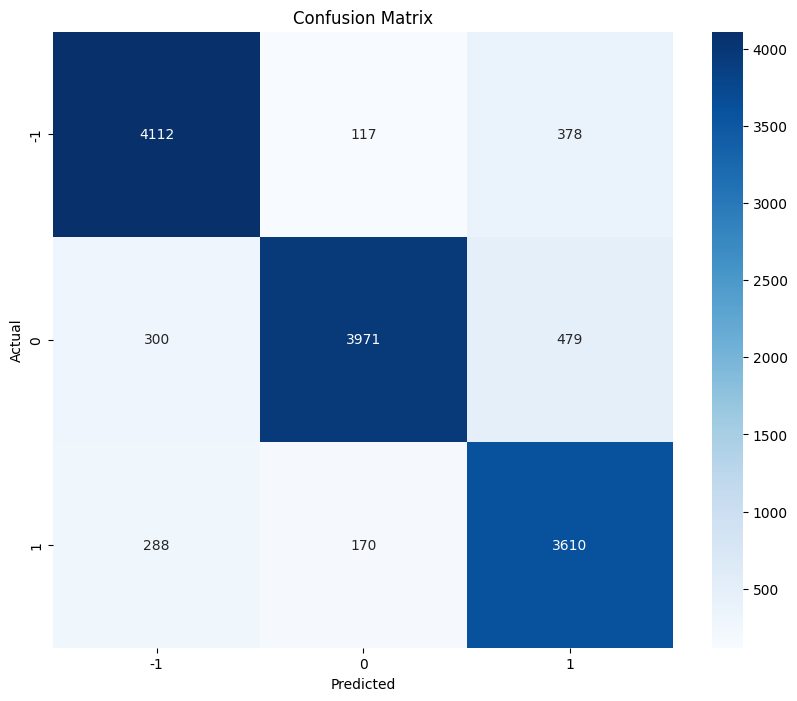

In [97]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

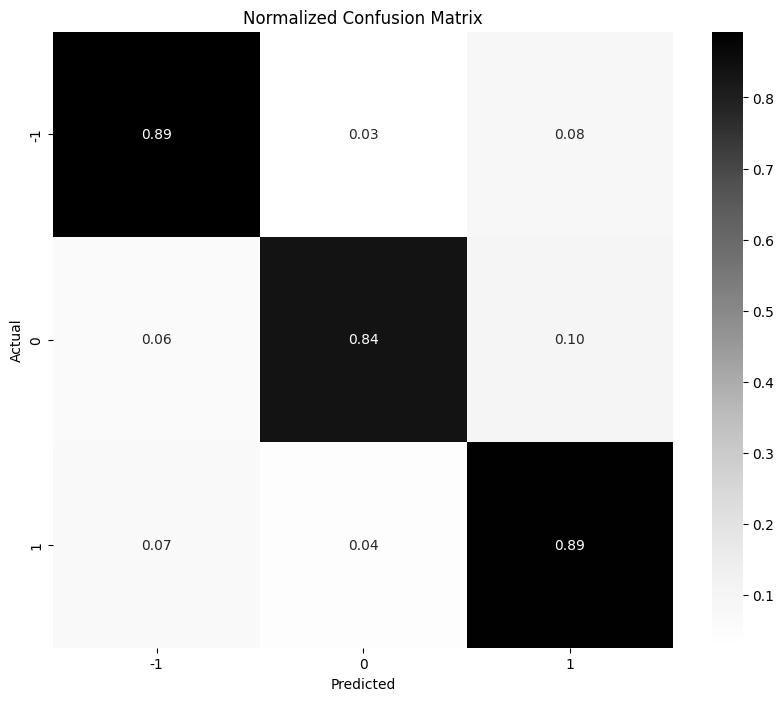

In [96]:
# Normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greys', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 2. I'll Try Now To Apply **Support Vector Machine** `(SVM)`
The training of an SVM model on the same preprocessed Arabic text data.

### Why SVM?
- Great for high-dimensional sparse data (like TF-IDF)
- Often more accurate for text classification
- Works well with few outliers and complex boundaries

In [89]:
svm_model = LinearSVC()

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

In [90]:
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.88      0.88      4607
           0       0.93      0.83      0.88      4750
           1       0.80      0.89      0.84      4068

    accuracy                           0.87     13425
   macro avg       0.87      0.87      0.86     13425
weighted avg       0.87      0.87      0.87     13425



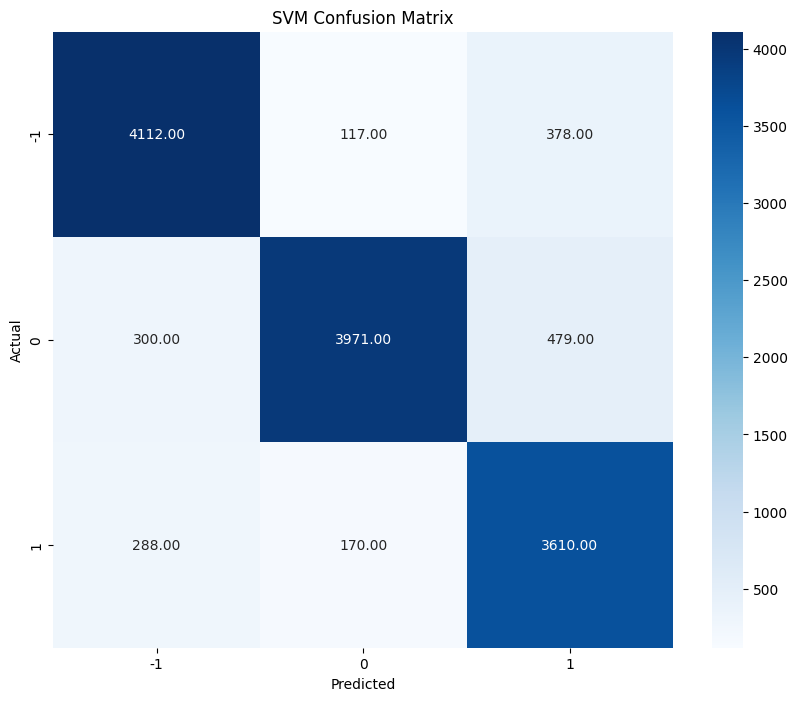

In [95]:
# Confusion matrix for SVM
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

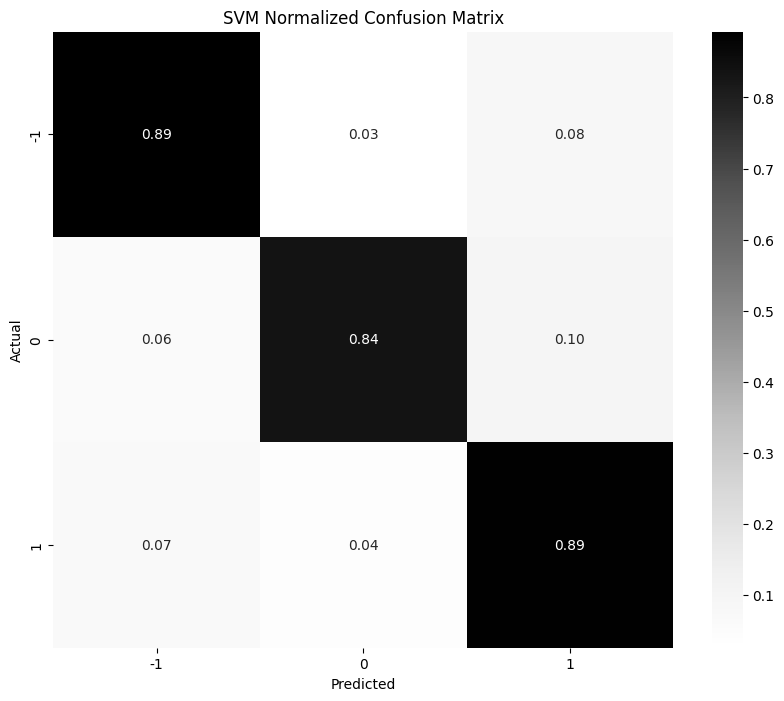

In [98]:
# Normalized confusion matrix for SVM
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greys', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("SVM Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 📊 Exploratory Data Visualization (You Put it To Be Optional but It's Valuable)

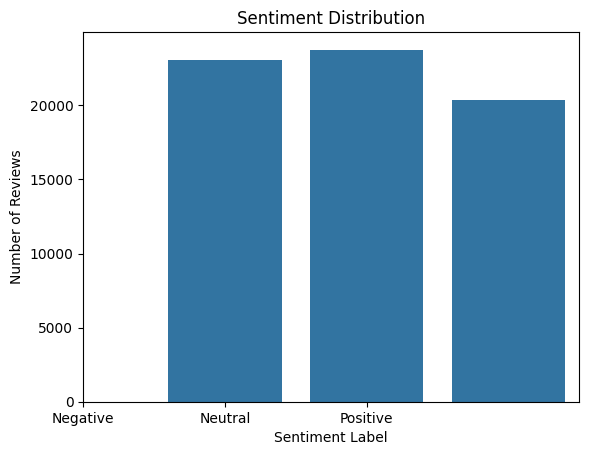

In [100]:
sns.countplot(x='rating', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
plt.show()

In [127]:
# Function to properly preprocess Arabic text
def preprocess_arabic_text(text):
    # Reshape the Arabic text
    reshaped_text = arabic_reshaper.reshape(text)
    # Apply bidirectional algorithm
    bidi_text = get_display(reshaped_text)
    return bidi_text

# Function to extract whole words (not characters) from text
def extract_arabic_words(text):
    # Split text into words
    words = re.findall(r'\S+', text)
    # Join with spaces to maintain word boundaries
    return ' '.join(words)

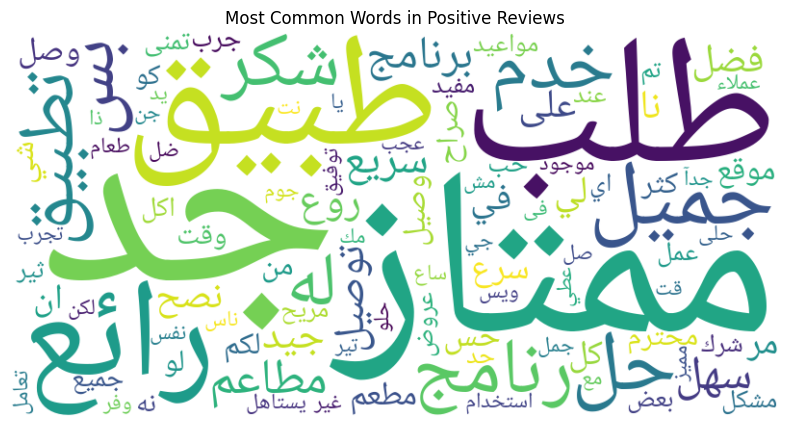

In [ ]:
positive_text = ' '.join(df[df['rating'] == 1]['final_text'])
negative_text = ' '.join(df[df['rating'] == -1]['final_text'])

positive_text_processed = preprocess_arabic_text(extract_arabic_words(positive_text))
negative_text_processed = preprocess_arabic_text(extract_arabic_words(negative_text))
  
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    font_path='NotoNaskhArabic-VariableFont_wght.ttf',
    collocations=False,  
    max_words=100,       
    min_word_length=2    
).generate(positive_text_processed)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Positive Reviews")
plt.show()

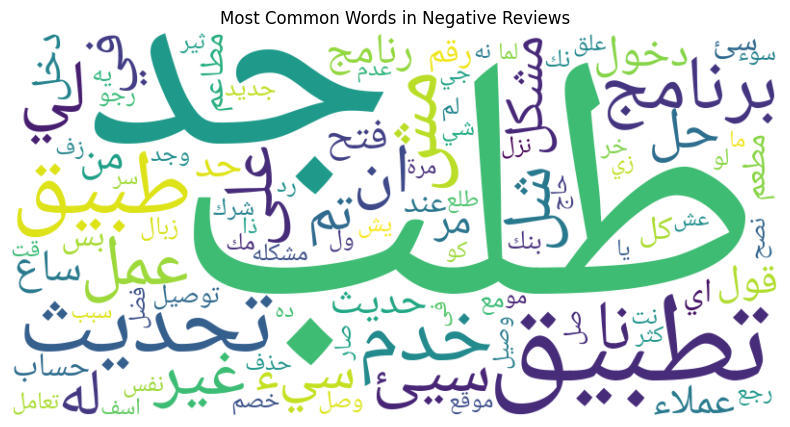

In [ ]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    font_path='NotoNaskhArabic-VariableFont_wght.ttf',
    collocations=False,  
    max_words=100,       
    min_word_length=2    
).generate(negative_text_processed)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Negative Reviews")
plt.show()